In [7]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP and ML tools
import spacy
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Optional: Encoding detection
import chardet

# Detect encoding for raw_text_data4.txt
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read(10000))
    return result['encoding']

# Load files with appropriate encoding
df1 = pd.read_csv('C:\\Users\\Administrator\\Downloads\\raw_text_data2.txt', sep='\t', encoding='utf-8')
df2 = pd.read_csv('C:\\Users\\Administrator\\Downloads\\raw_text_data3.txt', sep='\t', encoding='utf-8')
encoding3 = detect_encoding('C:\\Users\\Administrator\\Downloads\\raw_text_data4.txt')
df3 = pd.read_csv('C:\\Users\\Administrator\\Downloads\\raw_text_data4.txt', sep='\t', encoding=encoding3)

# Combine datasets
df_all = pd.concat([df1, df2, df3], ignore_index=True)
df_all.head(4)

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,S08_set3_a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,S08_set3_a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,S08_set3_a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,S08_set3_a4


In [9]:
# Drop nulls and duplicates
df_all.dropna(inplace=True)
df_all.drop_duplicates(inplace=True)

# Normalize text fields
df_all['Question'] = df_all['Question'].str.strip().str.lower()
df_all['Answer'] = df_all['Answer'].str.strip().str.lower()

# Add prompt length
df_all['prompt_length'] = df_all['Question'].apply(lambda x: len(x.split()))

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


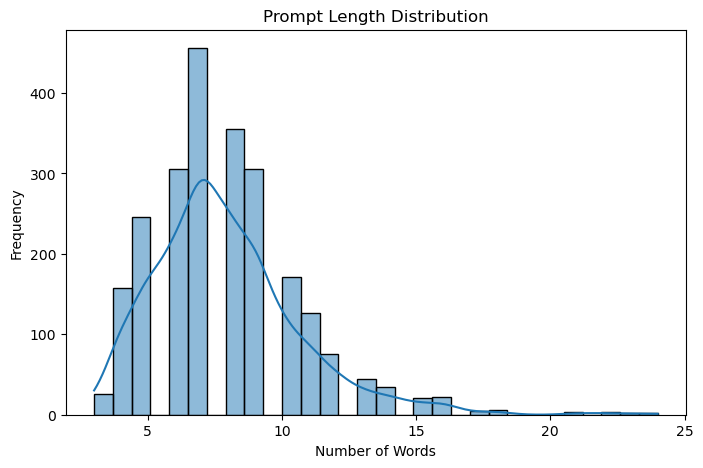

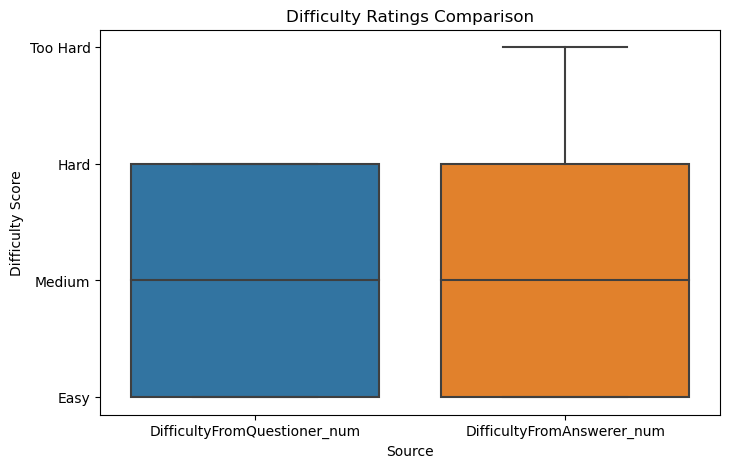

In [11]:
# Prompt length distribution
plt.figure(figsize=(8,5))
sns.histplot(df_all['prompt_length'], bins=30, kde=True)
plt.title('Prompt Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Map difficulty levels to numeric scores
difficulty_map = {
    'easy': 1,
    'medium': 2,
    'hard': 3,
    'too hard': 4
}

# Apply mapping
df_all['DifficultyFromQuestioner_num'] = df_all['DifficultyFromQuestioner'].map(difficulty_map)
df_all['DifficultyFromAnswerer_num'] = df_all['DifficultyFromAnswerer'].map(difficulty_map)

# Drop rows with missing values
df_cleaned = df_all.dropna(subset=['DifficultyFromQuestioner_num', 'DifficultyFromAnswerer_num'])

# Melt for boxplot
df_melted = df_cleaned[['DifficultyFromQuestioner_num', 'DifficultyFromAnswerer_num']].melt(
    var_name='Source', value_name='Difficulty'
)

# Plot boxplot
plt.figure(figsize=(8,5))
sns.boxplot(x='Source', y='Difficulty', data=df_melted)
plt.title('Difficulty Ratings Comparison')
plt.ylabel('Difficulty Score')
plt.yticks([1, 2, 3, 4], ['Easy', 'Medium', 'Hard', 'Too Hard'])
plt.show()

In [14]:
# Prompt complexity score
df_all['complexity_score'] = df_all['prompt_length'] + df_all['Question'].apply(lambda x: x.count('?'))

# Named entity count using spaCy
nlp = spacy.load("en_core_web_sm")
df_all['entity_count'] = df_all['Question'].apply(lambda x: len(nlp(x).ents))
df_all.head(4)

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile,prompt_length,DifficultyFromQuestioner_num,DifficultyFromAnswerer_num,complexity_score,entity_count
0,Abraham_Lincoln,was abraham lincoln the sixteenth president of...,yes,easy,easy,S08_set3_a4,10,1,1.0,11,3
1,Abraham_Lincoln,was abraham lincoln the sixteenth president of...,yes.,easy,easy,S08_set3_a4,10,1,1.0,11,3
2,Abraham_Lincoln,did lincoln sign the national banking act of 1...,yes,easy,medium,S08_set3_a4,9,1,2.0,10,2
3,Abraham_Lincoln,did lincoln sign the national banking act of 1...,yes.,easy,easy,S08_set3_a4,9,1,1.0,10,2


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_all['Question'])

# PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X.toarray())

print("Explained variance:", pca.explained_variance_ratio_.sum())

Explained variance: 0.11846320948637311


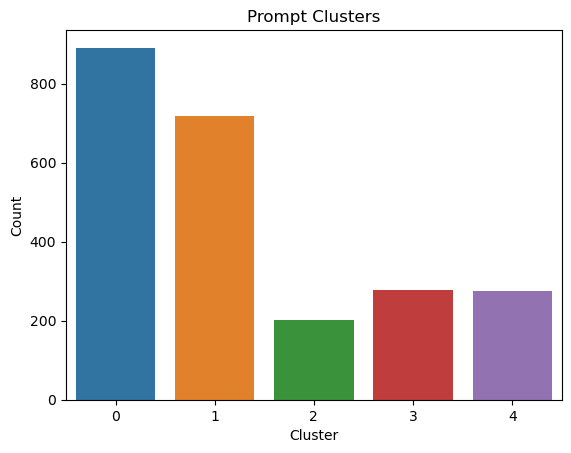

In [16]:
# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df_all['cluster'] = kmeans.fit_predict(X_pca)

# Cluster distribution
sns.countplot(x='cluster', data=df_all)
plt.title('Prompt Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [17]:
# Cluster-wise summary
summary = df_all.groupby('cluster')[['prompt_length', 'complexity_score', 'entity_count']].mean()
print(summary)

         prompt_length  complexity_score  entity_count
cluster                                               
0             8.048260          9.029181      0.797980
1             7.945607          8.927476      0.482566
2             6.826733          7.826733      0.118812
3             8.584229          9.577061      0.577061
4             7.374545          8.374545      0.396364


In [18]:
# Save cleaned and enriched dataset
df_all.to_csv('15_PromptAnalytics_Cleaned.csv', index=False)